In [11]:
import pandas as pd
import pandas.testing as tm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

In [12]:
data_filepath = "heart_failure_clinical_records_dataset.csv"
raw_data = pd.read_csv(data_filepath)

In [13]:
print('Number of positive samples:',sum(raw_data['DEATH_EVENT'] == 1))
print('Number of negative samples:',sum(raw_data['DEATH_EVENT'] == 0))

Number of positive samples: 96
Number of negative samples: 203


In [14]:
# We can choose to either remove or replace the NaN values and in this case there are so few that I can just remove them
raw_data.dropna(inplace = True)
# Divide the raw data into two dataframes based on the categorical heart failure variable
raw_data_neg, raw_data_pos = raw_data.groupby(['DEATH_EVENT'])
# We are taking an even sample of data from people who have had a heart failure and those who have not in order to reduce the bias of the model we will construct
df_filtered = pd.concat([raw_data_neg[1].sample(96),raw_data_pos[1].sample(96)]) 
# We want as much data as we can get while maintaining an similar number of positive and negative samples

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8d9982e50>,
      dtype=object)

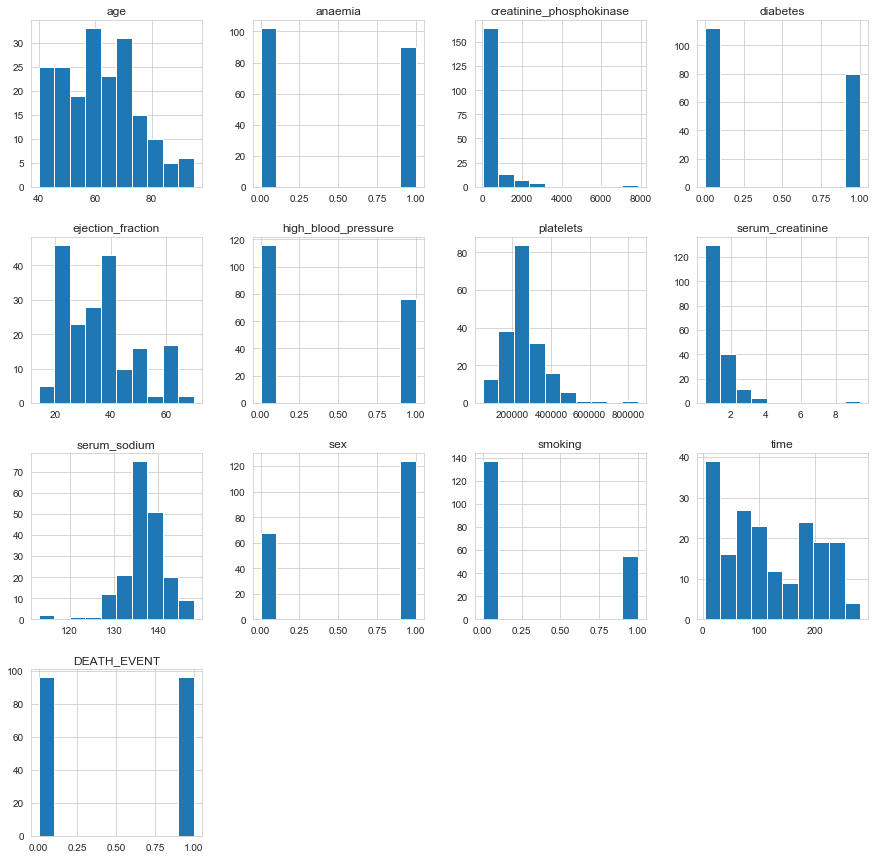

In [15]:
# We can visualize the new sample balanced around the categorical label we want to fit on
df_filtered.hist(figsize=(15,15)) 

In [16]:
# We can find better features by seeing what correlates well with the categorical label
df_filtered.corr() 

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.064590,-0.087774,-9.478235e-02,0.080040,0.140285,0.024648,0.147423,-0.037004,1.060814e-01,0.085451,-0.237626,2.734693e-01
anaemia,0.064590,1.000000,-0.167450,-3.175537e-02,0.052078,0.072031,-0.074560,0.033564,0.077482,-6.819690e-02,-0.133463,-0.178242,2.087414e-02
creatinine_phosphokinase,-0.087774,-0.167450,1.000000,3.013573e-03,-0.028508,-0.041580,-0.001616,0.000889,0.052937,5.817431e-02,-0.025213,-0.003248,1.015929e-01
diabetes,-0.094782,-0.031755,0.003014,1.000000e+00,-0.030336,-0.057608,0.111243,-0.043779,-0.099582,-1.472620e-01,-0.044787,-0.018340,8.210210e-18
ejection_fraction,0.080040,0.052078,-0.028508,-3.033596e-02,1.000000,0.050535,0.015106,0.060193,0.253495,-1.226175e-01,-0.076309,0.037744,-2.460684e-01
high_blood_pressure,0.140285,0.072031,-0.041580,-5.760765e-02,0.050535,1.000000,0.097186,-0.000557,0.100804,-1.354696e-01,0.005399,-0.164159,2.130072e-02
platelets,0.024648,-0.074560,-0.001616,1.112435e-01,0.015106,0.097186,1.000000,-0.054331,0.114287,-8.306753e-02,0.091607,-0.007817,-6.505655e-02
serum_creatinine,0.147423,0.033564,0.000889,-4.377868e-02,0.060193,-0.000557,-0.054331,1.000000,-0.197417,1.864055e-02,0.000929,-0.158333,2.744346e-01
serum_sodium,-0.037004,0.077482,0.052937,-9.958242e-02,0.253495,0.100804,0.114287,-0.197417,1.000000,-5.903946e-02,-0.059822,0.126177,-2.156952e-01
sex,0.106081,-0.068197,0.058174,-1.472620e-01,-0.122618,-0.135470,-0.083068,0.018641,-0.059039,1.000000e+00,0.396944,-0.012659,3.264440e-17


In [17]:
FEATURES = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']
LABELS = ['DEATH_EVENT']

# Spliting our data into the train/test split:
X = df_filtered[FEATURES].values
y = df_filtered[LABELS].values.reshape(1,-1)[0]
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,shuffle=True)

Testing Train/Test on a Model

In [18]:
# Logistic Regression test
clr = LogisticRegression(random_state = 0)
clr.fit(X_train, y_train)

# Predicting the Test set results
y_pred_clr = clr.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy = 55.17 %


Text(0.5, 1, 'Confusion Matrix')

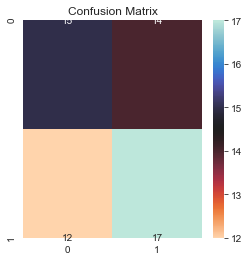

In [19]:
clr_cm = confusion_matrix(y_test, y_pred_clr)
acc_clr = accuracy_score(y_test, y_pred_clr)

print("Accuracy =","%.2f" % (acc_clr*100),"%")

plt.subplots(figsize=(4,4))
sns.heatmap(clr_cm, annot=True,cmap="icefire_r")
plt.title('Confusion Matrix')

Although the accuracy score is really bad we can see that the modeling will work and we can move forward with more modeling in the next section.